# Algorithm Outline
 1) Initialize grid, physical parameters, and field arrays for ψ (streamfunction) and ω (vorticity).
 2) Time-marching loop (for each time step):
    a) Solve Poisson equation ∇²ψ = -ω for ψ via Successive Over-Relaxation (SOR).
    b) Compute vorticity at the solid boundaries directly from ψ (using ω = -∇²ψ) and lid velocity.
    c) Advect and diffuse interior ω using the vorticity transport equation (explicit FTCS).
 3) After convergence or final time, post-process and plot vorticity and streamfunction.

## Import necessary libraries

In [2]:
from mpl_toolkits.mplot3d import Axes3D  # enables 3D plotting (not directly used here)
import numpy as np                      # numerical arrays and operations
import matplotlib.pyplot as plt         # plotting library

from qiskit.visualization import array_to_latex
from qiskit.quantum_info import Operator, SparsePauliOp
from qiskit import qasm2

from qiskit_aer import AerSimulator

from scipy.sparse import diags, eye, kron, identity, block_diag, csr_matrix
from scipy.sparse.linalg import spsolve

from classiq import *

authenticate();

c:\Users\Weidong\OneDrive - University of Calgary\Desktop\CFD\Quantum_Computing_Collaboration\.venv\Lib\site-packages\classiq\_internals\authentication\token_manager.py:101: UserWarning: Device is already registered.
Generating a new refresh token should only be done if the current refresh token is compromised.
To do so, set the overwrite parameter to true
  warnings.warn(


## Set problem parameters

In [29]:
# Python version 3.9 or newer

nx = 4       # number of grid points in x-direction
ny = 4       # number of grid points in y-direction
max_step = 200  # total number of time steps to march
visc = 0.1      # kinematic viscosity nu
u_wall = 1.0    # lid (top boundary) horizontal velocity

dt = 0.005      # time step size
dx = 1.0/(nx-1) # grid spacing (uniform) in both x and y

# === SOR (Successive Over-Relaxation) parameters for Poisson solver ===
max_iter = 100   # max iterations per time step for solving psi
beta = 1.5       # relaxation factor (>1 accelerates convergence)
max_err = 1e-4   # convergence tolerance for psi

# === Field arrays initialization ===
psi   = np.zeros((nx, ny))  # streamfunction array 
# np.zeros((4,4)) =
# [[0. 0. 0. 0.]
#  [0. 0. 0. 0.]
#  [0. 0. 0. 0.]
#  [0. 0. 0. 0.]]
omega = np.zeros((nx, ny))  # vorticity array

omega0 = np.zeros_like(omega)  # temporary array for previous vorticity
# coordinate arrays for plotting
x = np.zeros((nx, ny))
y = np.zeros((nx, ny))

# Fill coordinate arrays assuming domain [0,1]x[0,1]
for i in range(nx):
    for j in range(ny):
        x[i,j] = dx * i  # x-coordinate at grid index i
        y[i,j] = dx * j  # y-coordinate at grid index j

## Quantum solver for Streamfunction, $\psi$

The streamfunction is 0 along the four boundaries. Hence, we only need to update streamfunction at the interior nodes. 

In python, the interior nodes have indices from $1$ to $n_x-2$. 

### Setup $Ax=b$ for linear solvers

To calculate streamfunction, $\psi$, at the interior nodes, 

#### 1. Discretize the streamfunction equation

$$
\frac{\partial^{2}\psi}{\partial x^{2}}
\;+\;
\frac{\partial^{2}\psi}{\partial y^{2}}
\;=\;
-\omega
$$

to obtain

$$
\frac{\psi_{i+1,j} \;-\; 2\psi_{i,j} \;+\; \psi_{i-1,j}}{\Delta x^{2}}
\;+\;
\frac{\psi_{i,j+1} \;-\; 2\psi_{i,j} \;+\; \psi_{i,j-1}}{\Delta y^{2}}
\;=\;
-\omega_{i,j}
$$

assuming $\Delta x = \Delta y$, we have, for $i, j \in \mathbb{N}$

$$
4\psi_{i,j} - \psi_{i-1,j} - \psi_{i+1,j} - \psi_{i,j+1} - \psi_{i,j-1}
\;=\;
\omega_{i,j} \Delta x^{2} 
$$

We obtained a system of linear equations indexed by $(i, j)$.

We order these equations using **row-major order** (i.e., sweeping rows first):

$$
(i,j) \; = \; (1,1),\; (2,1),\; \dots,\; (n_x-2, 1),\; 
(1,2),\; (2,2),\; \dots,\; (n_x-2, 2),\; \dots,\; 
(1, n_y-2),\; (2, n_y-2),\; \dots,\; (n_x-2, n_y-2)
$$

#### 2. Convert to $Ax=b$.

Here, $x$ is the $\psi$ that we are trying to solve, $b$ is $\omega \Delta x^{2}$ on the right-hand side, and $A$ is the matrix of coefficients, made up of 4 and -1 and 0. 

To do this, we define the function `get_b()` to obtain the $b$ from the interior values of $\omega$, and the function `get_A()` to obtain the matrix $A$. 

There a two corner cases I want to talk about. For $(i,j)$ along the inside boundary, 
say, the bottom left corner at $(1,1)$, 
the equation becomes

$$
4\psi_{1,1} - \psi_{0,1} - \psi_{2,1} - \psi_{1,2} - \psi_{1,0}
\;=\;
\omega_{1,1} \Delta x^{2} 
$$

which, since $\psi_{0,1} = \psi_{1,0} = 0$, equals to

$$
4\psi_{1,1} - \psi_{2,1} - \psi_{1,2}
\;=\;
\omega_{1,1} \Delta x^{2} 
$$

More interestingly, at the bottom right corner at $(n_x-2,1)$, we have

$$
4\psi_{n_x-2,1} - \psi_{n_x-3,1} - \psi_{n_x-1,1} - \psi_{n_x-2,2} - \psi_{n_x-2,0}
\;=\;
\omega_{n_x-2,1} \Delta x^{2} 
$$
which implies, since $\psi_{n_x-1,1} = \psi_{n_x-2,0} = 0$,
$$
4\psi_{n_x-2,1} - \psi_{n_x-3,1} - \psi_{n_x-2,2}
\;=\;
\omega_{n_x-2,1} \Delta x^{2} 
$$

As a result, in the matrix $A$, for the diagonal entry corresponding to the index $(n_x-2,1)$, 
there is a "-1" immediately to the left, but not immediately to the right, and another "-1"
$n_x-1$ spaces to the right. 

#### 3. Solve $Ax=b$

Use classical or quantum solvers.

#### 4. Update $\psi$ using $x$. 

We define the function `recover_full_psi_from_flat()` to recover $\psi$. 


Define `get_A()`, `get_b()`, `recover_full_psi_from_flat()`, and `pad_to_power_of_two()` for quantum solvers.

In [ ]:
# Prompt for generative AI to generate the get_A() function. 
"""
Given nx, ny and dx, define a function that construct the following symmetric matrix:
0. the symmetric matrix has size (nx-2)*(ny-2)
1. on the diagonal, we have 4
2. on the two sub-diagonal beside the main diagonal, has -1. 
3. for each row i, (i, i+nx-2) and (i, i-(nx-2)) also has -1. If index is outside of range, ignore. 
In other words, the diagonal that is shifted left and right from the main diagonal by (nx-2) also has -1.
"""

def get_A(nx: int, ny: int):
    """
    Build the (nx-2)*(ny-2) five-point Laplacian matrix
    with 4 on the diagonal, -1 on the ±1 sub/super-diagonals
    (excluding row-wrap connections), and -1 on the ±(nx-2) diagonals.
    Returns a CSR matrix of shape (N, N), where N=(nx-2)*(ny-2).
    
    We assume that the value of the discretized quantity (streamfunction psi in this case) at the 4 boundaries are 0. 
    Notice that in Python the indices range from psi[0,0] to psi[nx-1, ny-1], 
    where as in Engineering, the indices range from psi_(1,1) to psi_(nx,ny)
    """
    N_x = nx - 2
    N_y = ny - 2
    N   = N_x * N_y

    # main diagonal
    main =  4 * np.ones(N, dtype=float)

    # ---- horizontal neighbors (offset ±1), but zero out wrap-around
    # create a length-(N-1) array of -1’s
    off1 = -np.ones(N-1, dtype=float)
    # mask out entries where (i,i+1) would jump from end of one row to next
    idx   = np.arange(N-1)
    wrap  = (idx + 1) % N_x == 0
    off1[wrap] = 0.0

    # ---- vertical neighbors (offset ±N_x), no wrap issues
    offNx = -np.ones(N - N_x, dtype=float)

    # assemble
    diags_data = [ main,
                off1, off1,
                offNx, offNx ]
    offsets    = [  0,
                -1,   1,
                -N_x, N_x ]

    A = diags(diags_data, offsets, shape=(N, N), format='csr')
    return A

# # After building A as a CSR matrix you can use:
#    dense_A = A.toarray()        # convert to NumPy array

# # Or use qiskit for better visualization
# from qiskit.visualization import array_to_latex
# display(array_to_latex(A.toarray()))

def get_b(omega, dx):
    """
    Given vorticity omega os size nx x ny,
    extract omega from the interior and flatten to a vector.
    """
    b = omega[1:-1, 1:-1].flatten() * dx**2
    return b


def pad_to_power_of_two(
    A: csr_matrix | None   = None,
    b: np.ndarray  | None  = None
) -> csr_matrix | np.ndarray | tuple[csr_matrix, np.ndarray]:
    
    """
    Pad a sparse CSR matrix and/or vector to the next power-of-two dimension
    for qubit-based solvers.

    You may supply either:
      - A only  => returns padded A
      - b only  => returns padded b
      - A and b => returns (Apad, bpad)

    Parameters
    ----------
    A : scipy.sparse.csr_matrix, optional
        Original square matrix of shape (N, N).
    b : numpy.ndarray, optional
        Original right-hand side vector of length N.

    Returns
    -------
    Apad : scipy.sparse.csr_matrix
        Padded matrix of shape (2^n, 2^n) if A was provided.
    bpad : numpy.ndarray
        Padded RHS vector of length 2^n if b was provided.
    (Apad, bpad) : tuple
        If both A and b are given.
    """
    # Determine original size N
    if A is not None:
        N = A.shape[0]
    elif b is not None:
        b = np.asarray(b).flatten()
        N = b.shape[0]
    else:
        raise ValueError("Must provide at least one of A or b to pad.")

    # Compute next power of two ≥ N
    n_bits = (N - 1).bit_length()
    N2 = 1 << n_bits
    M = N2 - N

    # If already power-of-two, just return copy(s)
    if M == 0:
        if A is not None and b is not None:
            return A.copy(), b.copy()
        elif A is not None:
            return A.copy()
        else:
            return b.copy()

    # Build padding structures
    pad_id = identity(M, dtype=(A.dtype if A is not None else np.float64), format='csr')

    # Pad A if requested
    if A is not None:
        Apad = block_diag([A, pad_id], format='csr')
    # Pad b if requested
    if b is not None:
        bpad = np.empty(N2, dtype=b.dtype)
        bpad[:N] = b
        bpad[N:] = 0

    # Return according to inputs
    if A is not None and b is not None:
        return Apad, bpad
    elif A is not None:
        return Apad
    else:
        return bpad


def recover_full_psi_from_flat(psi_vec: np.ndarray, nx: int, ny: int, boundary: float = 0.0) -> np.ndarray:
    """
    Rebuild a full (nx x ny) array from a flattened interior vector psi_vec.

    Parameters
    ----------
    psi_vec : 1D np.ndarray, length = (nx-2)*(ny-2)
        Flattened (row-major) interior values.
    nx, ny : int
        Full grid dimensions.
    boundary : float, optional
        Dirichlet boundary value (default 0.0).

    Returns
    -------
    psi_full : 2D np.ndarray, shape (nx, ny)
        Full array with psi_full[1:-1,1:-1] filled from psi_vec
        and all boundaries set to `boundary`.
    """
    expected = (nx-2) * (ny-2)
    if psi_vec.size != expected:
        raise ValueError(f"Expected psi_vec of length {expected}, got {psi_vec.size}")
    
    # Reshape back to 2D interior
    interior = psi_vec.reshape((nx-2, ny-2))
    
    # Use psi_vec for the interior nodes
    psi_full = np.full((nx, ny), boundary, dtype=psi_vec.dtype)
    psi_full[1:-1, 1:-1] = interior
    
    return psi_full

In [6]:
A_dis = get_A(6,5).toarray()
print(A_dis)

[[ 4. -1.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  4. -1.  0.  0. -1.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  4. -1.  0.  0. -1.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  4.  0.  0.  0. -1.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  4. -1.  0.  0. -1.  0.  0.  0.]
 [ 0. -1.  0.  0. -1.  4. -1.  0.  0. -1.  0.  0.]
 [ 0.  0. -1.  0.  0. -1.  4. -1.  0.  0. -1.  0.]
 [ 0.  0.  0. -1.  0.  0. -1.  4.  0.  0.  0. -1.]
 [ 0.  0.  0.  0. -1.  0.  0.  0.  4. -1.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  0.  0. -1.  4. -1.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  0.  0. -1.  4. -1.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.  0.  0. -1.  4.]]


In [7]:
display(array_to_latex(get_A(6,5).toarray()))

<IPython.core.display.Latex object>

### Prepare for HHL

We have obtained Ax=b of appropriate size from the previous step. 

The matrix, $A$, is hermitian. However, its eigenvalues are not within 0 and 1. To apply HHL, we have to convert $A$.

We construct the quantum circuit for HHL, before evaluating it. 

For evaluation, we try ideal statevector simulation. 

In [ ]:
# Using statevector AerSimulator
backend = AerSimulator()

C:\Users\Weidong\AppData\Local\Temp\ipykernel_85692\4266703871.py:9: RuntimeWarning: invalid value encountered in divide
  b_norm = bpad / np.linalg.norm(b) # Must go through 1 timestep, otherwise, b = 0.


In [12]:
# Check if a csr_matrix is hermitian.

def is_hermitian_sparse(A: csr_matrix, tol=1e-10) -> bool:
    """
    Check if a scipy.sparse.csr_matrix is Hermitian (A = A†).
    
    Parameters:
        A (csr_matrix): Input sparse matrix.
        tol (float): Numerical tolerance for element-wise comparison.
    
    Returns:
        bool: True if A is Hermitian within the given tolerance.
    """
    if A.shape[0] != A.shape[1]:
        return False  # must be square
    
    diff = (A - A.getH()).tocoo()  # getH() is conjugate transpose
    return np.all(np.abs(diff.data) < tol)

print("Is the matrix hermitian?")
is_hermitian_sparse(get_A(6,5))


Is the matrix hermitian?


True

We first want to estimate the eigenvalues of A so that we can prepare a matrix whose eigenvalue falls between 0 and 1 for QPE. 

### Direct formula for eigenvalues

For pentadiagonal Toeplitz matrices that we obtain from discretizing the streamfunction-vorticity equation, 
we have a direct formula for its eigenvalues. 

#### 1. Exact spectrum (separation–of–variables)

For indices $(p,\; q)$ of $A$, and let $(N_x, N_y) = (n_x-2, n_y-2)$,
$$
p = 1, \dots, N_x,\;\; q = 1, \dots, N_y
$$

The eigenvectors factor into sines; the eigenvalues are
$$
\lambda_{p,q}
= 4
\;-\;2\cos\!\Bigl(\frac{\pi\,p}{N_x + 1}\Bigr)
\;-\;2\cos\!\Bigl(\frac{\pi\,q}{N_y + 1}\Bigr),
\quad
p = 1\ldots N_x,\;\;q = 1\ldots N_y.
$$

#### 2. Immediate upper and lower bounds

**Smallest eigenvalue** (take $p=q=1$)  
$$
\lambda_{\min}
= 4
\;-\;2\cos\!\Bigl(\frac{\pi}{N_x + 1}\Bigr)
\;-\;2\cos\!\Bigl(\frac{\pi}{N_y + 1}\Bigr).
$$

> Disregard this: For large grids $(N_x, N_y \gg 1)$, use $\cos\theta \approx 1 - \tfrac{\theta^2}{2}$:

$$
\lambda_{\min}
\approx
\frac{\pi^2}{(N_x + 1)^2}
\;+\;
\frac{\pi^2}{(N_y + 1)^2}.
$$

**Largest eigenvalue** (take $p=N_x,\;q=N_y$)  
$$
\lambda_{\max}
= 4
\;+\;2\cos\!\Bigl(\frac{\pi}{N_x + 1}\Bigr)
\;+\;2\cos\!\Bigl(\frac{\pi}{N_y + 1}\Bigr)
\;<\;8.
$$

Hence a quick global bound for any grid is
$$
\frac{\pi^2}{(N_x + 1)^2}
\;+\;
\frac{\pi^2}{(N_y + 1)^2}
\;\le\;
\lambda
\;\le\;
8.
$$



In [43]:
# Calculating eignenvalues of A, using eigen solver.
# (nx,ny) = (6,5), A_dis is 12x12

w, v = np.linalg.eig(A_dis)

m = 32  # Precision of a binary representation, e.g. 32 binary digits
sign = lambda num: "-" if num < 0 else ""  # Calculate sign of a number
binary = lambda fraction: str(
    np.binary_repr(int(np.abs(fraction) * 2 ** (m))).zfill(m)
).rstrip(
    "0"
)  # Binary representation of a fraction
print("Results for (6,5) grid, A is 12x12.")
print("Eigenvalues:")
for eig in sorted(w):
    print(f"{sign(eig)}0.{binary(eig.real)} =~ {eig.real}")

# Claculating eigenvalues of A, using direct formula

def eigenvalues_laplacian(nx: int, ny: int) -> np.ndarray:
    """
    Compute the eigenvalues of the 5‑point Laplacian, pentadiagonal matrix on an
    (nx-2) by (ny-2) interior grid.

    Returns a 2D array of shape ((nx-2), (ny-2)) where
        Lambda[p-1, q-1] = 4 - 2*cos(pi*p/(nx-1)) - 2*cos(pi*q/(ny-1))
    for p=1..nx-2, q=1..ny-2.
    """
    Nx = nx - 2
    Ny = ny - 2

    # indices p=1..Nx, q=1..Ny
    p = np.arange(1, Nx+1)
    q = np.arange(1, Ny+1)

    # compute the two cosine terms
    cos_p = np.cos(np.pi * p / (Nx + 1))    # shape (Nx,)
    cos_q = np.cos(np.pi * q / (Ny + 1))    # shape (Ny,)

    # build the full (Nx x Ny) array via broadcasting
    Lambda = 4 \
           - 2 * cos_p[:, None] \
           - 2 * cos_q[None, :]

    return Lambda

# Example usage:
nx1, ny1 = 6, 5
eigvals = eigenvalues_laplacian(nx1, ny1)
for eig in sorted(eigvals.ravel()):
    print(eig.real)

print("Are the two results the same?")
np.allclose(sorted(w), sorted(eigvals.ravel()), rtol=1e-20)


def eigenrange_laplacian(nx, ny):
    Nx = nx - 2
    Ny = ny - 2

    min = (4 
    - 2 * np.cos(np.pi / (Nx + 1))
    - 2 * np.cos(np.pi / (Ny + 1)))

    max = (4 
    + 2 * np.cos(np.pi / (Nx + 1))
    + 2 * np.cos(np.pi / (Ny + 1)))

    return min, max

Results for (6,5) grid, A is 12x12.
Eigenvalues:
0.1111011110111110100111111101111 =~ 0.9677524488770097
0.11111011110111110100111111101111 =~ 1.967752448877013
0.100110000111001000100001100100011 =~ 2.381966011250108
0.1100110100001011011001001101010001 =~ 3.2038204263768
0.110110000111001000100001100100011 =~ 3.381966011250105
0.111100101111010010011011001010111 =~ 3.7961795736231996
0.10000110100001011011001001101010001 =~ 4.203820426376798
0.10010011110001101110111100110111001 =~ 4.618033988749892
0.1001100101111010010011011001010111 =~ 4.796179573623213
0.10110011110001101110111100110111001 =~ 5.618033988749896
0.11000001000010000010110000000100001 =~ 6.032247551122988
0.11100001000010000010110000000100001 =~ 7.032247551122998
0.96775244887701
1.96775244887701
2.381966011250105
3.2038204263768
3.381966011250105
3.7961795736232
4.2038204263768
4.618033988749895
4.7961795736232
5.618033988749895
6.03224755112299
7.03224755112299
Are the two results the same?


In [46]:
Nx = 4
Ny = 3
eigvals_min = (4 
    - 2 * np.cos(np.pi / (Nx + 1))
    - 2 * np.cos(np.pi / (Ny + 1)))
print(eigvals_min)

eigvals_max = (4 
    + 2 * np.cos(np.pi / (Nx + 1))
    + 2 * np.cos(np.pi / (Ny + 1)))
print(eigvals_max)

print(eigenrange_laplacian(6,5))
print(eigenrange_laplacian(4,4))


0.96775244887701
7.03224755112299
(0.96775244887701, 7.03224755112299)
(1.9999999999999998, 6.0)


### Prepare Hamiltonian evolution of A

In [47]:
A = get_A(nx, ny)
b = get_b(omega, dx)
print(A.toarray())
print(b)

eigen_values = eigenvalues_laplacian(nx,ny)
print(eigen_values)

[[ 4. -1. -1.  0.]
 [-1.  4.  0. -1.]
 [-1.  0.  4. -1.]
 [ 0. -1. -1.  4.]]
[0. 0. 0. 0.]
[[2. 4.]
 [4. 6.]]


In [ ]:
eigen_min, eigen_max = eigenrange_laplacian(nx, ny)

In [ ]:
# Decompose A_norm into Pauli strings

hamiltonian = matrix_to_hamiltonian(A)
n = len(hamiltonian[0].pauli)

print("Pauli strings list: \n")
for pterm in hamiltonian:
    print(pterm.pauli, ": ", np.round(pterm.coefficient, 7))

print("\nNumber of qubits for matrix representation =", n)


### Classiq HHL algorithm

In [ ]:
# Define classiq functions

# Encode b as amplitudes
@qfunc
def load_b(amplitudes: CArray[CReal], state: Output[QArray]) -> None:
    prepare_amplitudes(amplitudes, 0.0, state)


from classiq.qmod.symbolic import floor, log

# Parameters for the initial state preparation
amplitudes = b.tolist()

# Parameters for the QPE
precision = 4

# Function for the main quantum program
@qfunc
def hhl(
    rhs_vector: CArray[CReal],
    precision: CInt,
    hamiltonian_evolution_with_power: QCallable[CInt, QArray],
    state: Output[QArray],
    phase: Output[QNum],
    indicator: Output[QBit],
):
    # Allocate "precision" number of qubits. All of which are fractions: 0.123456. For comparison consider 12.3456
    # The quantum register that holds this info is called "phase".
    allocate(num_qubits=precision, is_signed=UNSIGNED, fraction_digits=precision, out=phase) 

    # Prepare "b", assigned to a quantum register called "state". 
    load_b(amplitudes=amplitudes, state=state)

    # Allocate a single qubit to the quantum register called "indicator". 
    # We will perform controlled rotations onto this "indicator". 
    allocate(indicator)
    
    # Perform quantum phase estimation and eigenvalue inversion
    within_apply(
        # Within block: on the outside, i.e., QPE and QPE^-1
        lambda: qpe_flexible(
            # A function that performs U operation k (or 2^k) times on the quantum register, "state", which encodes b. 
            unitary_with_power =
                # hamiltonian_evolution_with_power(k, qreg) is the function that generates U from A, and can repeat itself k (or 2^k) times. 
                lambda k: hamiltonian_evolution_with_power(k, state),
            # The outputs (eigenvalues info) are stored in the "phase" quantum register
            phase=phase,
        ),
        # Apply block: on the inside
        # Generates C/lambda*ket1, where C = 1 / 2**phase.size. Note that C must be a lower bound for the smallest eigenvalue.
        # However, this also explains why synthesis takes so long. 
        # We are supposed to perform the controlled rotations with eigenvalues as controls, and the indicator is the target.
        # But here, it computes classical arithmetic to obtain C/lambda given variable lambda, then assigns C/lambda to a qubit. 
        lambda: assign_amplitude( 
            (1 / 2**phase.size) / phase, # This is C/lambda
            indicator
        ),
    )

# Prepare quantum model for simulation
# With optional execution preferences.
def hhl_model(main, backend_preferences=None):
    qmod_hhl = create_model(
        main,
        # execution_preferences=ExecutionPreferences(
        #     num_shots=1, backend_preferences=backend_preferences
        # ),
    )
    return qmod_hhl

# Convert to qiskit circuit
def hhl_circ(main):
    qmod_hhl = create_model(main)
    qprog = synthesize(qmod_hhl)
    qcode = qprog.to_program()
    qc = qasm2.loads(qcode.code)
    return qc

def eval_qc(qc, backend):
    qc_transpiled = transpile(circuits=qc, 
                            backend=backend, 
                            optimization_level=2, 
                            layout_method="dense")
    qc_transpiled.save_statevector()
    
    job = simulator.run(qc_transpiled)
    result = job.result()
    
    sv = result.get_statevector(qc_transpiled)
    
    return sv

# Postprocess


## SOR solver for Streamfunction, psi

In [6]:
def solve_streamfunction_sor(psi_init, omega, dx, beta, max_iter, max_err):
    """
    Solve ∇²ψ = –ω on the interior of a (nx×ny) grid by SOR in place.

    Parameters
    ----------
    psi : 2D ndarray, shape (nx,ny)
        Initial guess for the streamfunction.
    omega : 2D ndarray, shape (nx,ny)
        Current vorticity field (source term).
    dx : float
        Grid spacing (assumed equal in x and y).
    beta : float
        Relaxation factor (1<beta<2 for over–relaxation).
    max_iter : int
        Maximum number of SOR sweeps.
    tol : float
        Convergence tolerance on the L1 change in ψ.

    Returns
    -------
    psi : 2D ndarray
        Updated streamfunction (in place).
    iters : int
        Number of iterations actually performed.
    """
    nx, ny = psi_init.shape
    psi = psi_init.copy()
    for it in range(1, max_iter + 1):
        psi_old = psi.copy()
        # Update interior points using SOR
        for i in range(1, nx-1): # range(1,3) = [1, 2]
            for j in range(1, ny-1):
                # 5-point Laplacian + source term (vorticity)
                psi[i, j] = (
                    (1 - beta)*psi[i, j]
                    + (beta * 0.25) * (
                        psi[i+1, j] + psi[i-1, j]
                        + psi[i, j+1] + psi[i, j-1]
                        + dx*dx * omega[i, j]
                    )
                )
        # check convergence (L1 norm)
        err = np.sum(np.abs(psi - psi_old))
        if err < max_err:
            return psi, it, err
    return psi, max_iter, err

## Vorticity transport

First, define `vorticity_transport()` function to update the vorticity (omega) to the next timestep. The inital vorticity is all zero.

In [5]:
def vorticity_transport(psi, omega):
    """The goal is to be able to perform a single timestep for testing and verification.
    To print or save the omega at each timestep. 
    
    Given psi and omega from the current timestep, calculate omega for the next timestep.
    
    Return updated omega
    """
    
    omega_next = omega.copy() # Initialize next timestep vorticity
    omega0 = omega.copy()  # store old vorticity
    
        # ----- 1) Update omega for the next timestep -----
    #   a) Apply and calculate boundary vorticity at walls
    # Vorticity ω is computed at the walls directly from ψ (streamfunction) via ω = -∇²ψ,
    # with an extra term on the moving lid: ω = -2ψ/dx² - 2u_wall/dx for y = 1
    # This sets ω on the bottom, top, left and right boundaries.
    
    # bottom wall (y=0): u=0 => psi=0 => vorticity = -2*psi[...]/dx^2
    omega_next[1:nx-1, 0] = -2.0 * psi[1:nx-1, 1] / (dx*dx)
    # top lid (y=1): u=u_wall, psi=0 => includes lid velocity contribution
    omega_next[1:nx-1, ny-1] = -2.0 * psi[1:nx-1, ny-2] / (dx*dx) - 2.0 * u_wall / dx
    # left wall (x=0): psi=0
    omega_next[0, 1:ny-1] = -2.0 * psi[1, 1:ny-1] / (dx*dx)
    # right wall (x=1): psi=0
    omega_next[nx-1, 1:ny-1] = -2.0 * psi[nx-2, 1:ny-1] / (dx*dx)
    
    #   b) Compute interior vorticity transport: advect + diffuse
    # Interior vorticity ω at each grid point is updated using the vorticity transport equation:
    # ∂ω/∂t + u ∂ω/∂x + v ∂ω/∂y = ν ∇²ω, discretized explicitly (FTCS).
    # Here ω0 holds the previous time step's vorticity.
    for i in range(1, nx-1): # inner nodes
        for j in range(1, ny-1): # inner nodes
            # compute convective term: u * d(omega)/dx + v * d(omega)/dy
            adv =  -0.25 * (
                    (psi[i,j+1] - psi[i,j-1]) * (omega0[i+1,j] - omega0[i-1,j])
                  - (psi[i+1,j] - psi[i-1,j]) * (omega0[i,j+1] - omega0[i,j-1])
                ) / (dx*dx)
            # diffusion term: nu * Laplacian(omega)
            diff = visc * (
                    omega0[i+1,j] + omega0[i-1,j]
                    + omega0[i,j+1] + omega0[i,j-1]
                  - 4.0 * omega0[i,j]
                ) / (dx*dx)
            # update vorticity explicitly
            omega_next[i,j] = omega0[i,j] + dt * (adv + diff)
    return omega_next


## Tests for poisson discretization

First, perform two timestep iterations to obtain vorticity at the timestep 2, omega_2. 

Next, solve for streamfunction at timestep 2, psi_2, using both the SOR and classical linear solver (by solving Ax=b). 

Compare the results. We want to verify the correctness of our discretized poisson system of linear equations, A and b, which we obtained using functions `get_b()` and `get_A()`.

Since SOR algorithm is only an approximation with error within `max_err` and Classical linear solver outputs the exact solution. For more accurate comparison, set `max_err` sufficiently low. 

In [9]:
# Obtain omega_2

omega_1 = vorticity_transport(psi=psi, omega=omega)
psi_1, *_ = solve_streamfunction_sor(psi, omega_1, dx, beta, max_iter, max_err=1e-4)
print(omega_1, psi_1, sep="\n\n")

print("Second evolution:")
omega_2 = vorticity_transport(psi=psi_1, omega=omega_1)
print(omega_2)

psi_2, *_ = solve_streamfunction_sor(psi_1, omega_2, dx, beta, max_iter, max_err=1e-8)
print(f"Streamfunction solution from SOR: \n {psi_2}")

[[ 0. -0. -0.  0.]
 [-0.  0.  0. -6.]
 [-0.  0.  0. -6.]
 [ 0. -0. -0.  0.]]

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Second evolution:
[[ 0.    -0.    -0.     0.   ]
 [-0.     0.    -0.027 -6.   ]
 [-0.     0.    -0.027 -6.   ]
 [ 0.    -0.    -0.     0.   ]]
Streamfunction solution from SOR: 
 [[ 0.        0.        0.        0.      ]
 [ 0.       -0.000375 -0.001125  0.      ]
 [ 0.       -0.000375 -0.001125  0.      ]
 [ 0.        0.        0.        0.      ]]


In [14]:
# Set up for classical linear solver
A_dis = get_A(nx, ny)
print(A_dis.toarray())

b_dis = get_b(omega_2, dx)
print(b_dis)

x_dis = spsolve(A_dis, b_dis)

psi_full = recover_full_psi_from_flat(x_dis, nx, ny)
print("Streamfunction from classical linear solver: ")
print(psi_full)

[[ 4. -1. -1.  0.]
 [-1.  4.  0. -1.]
 [-1.  0.  4. -1.]
 [ 0. -1. -1.  4.]]
[ 0.    -0.003  0.    -0.003]
Streamfunction from classical linear solver: 
[[ 0.        0.        0.        0.      ]
 [ 0.       -0.000375 -0.001125  0.      ]
 [ 0.       -0.000375 -0.001125  0.      ]
 [ 0.        0.        0.        0.      ]]


In [16]:
# Compare classical result with SOR result:

print("Is SOR solution 1e-4 close to classical linear solver solution?")
np.allclose(psi_2, psi_full, rtol=1e-4, atol=1e-4)

Is SOR solution 1e-4 close to classical linear solver solution?


True

In [ ]:
example_A = get_A(10,10).toarray()

np.savetxt("clipboard.txt", example_A, delimiter='\t', fmt="%.6f")

## Time-marching Loop

In [ ]:
# Time-marching loop
t_current = 0.0
for tstep in range(max_step):
    # ----- 1) Update omega for the next timestep, using vorticity transport with FTCS discretization -----
    omega = vorticity_transport(psi, omega)
    
    # ----- 2) Solve Poisson equation for streamfunction psi -----
    # Given omega_new for tstep+1, returns updated streamfunction, psi[:,:] for tstep+1. 
    
    # SOR
    psi, sor_iters, err = solve_streamfunction_sor(
        psi, omega, dx, beta, max_iter, max_err)
    # can use psi, *_ = solve_streamfunction_sor(...) to collect just the psi. 
    
    t_current += dt  # advance physical time

## Post-processing: plot results

Converged psi error: 7.66e-05


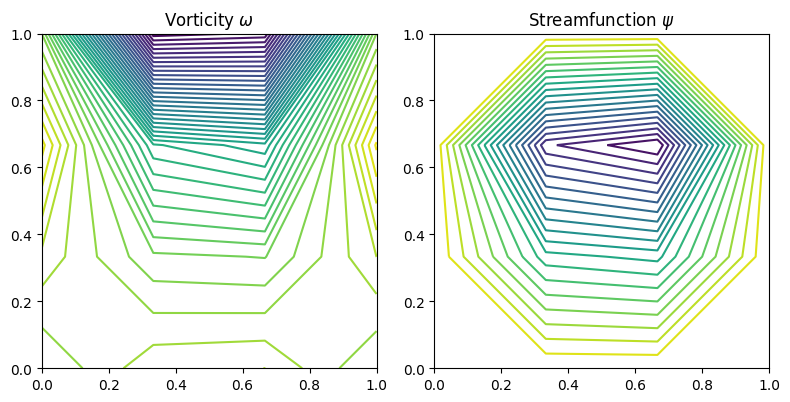

In [6]:

print(f"Converged psi error: {err:.2e}")
# Plot vorticity and streamfunction side-by-side
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.contour(x, y, omega, 40)
plt.title(r"Vorticity $\omega$")
plt.axis('square')

plt.subplot(1,2,2)
plt.contour(x, y, psi, 20)
plt.title(r"Streamfunction $\psi$")
plt.axis('square')

plt.tight_layout()
plt.show()